# Part-B: Active Learning with Logistic Regression

In this part, we implement **Active Learning** to reduce the number of labeled samples
required to train a good classifier.

Unlike Part-A, we assume that the training dataset is **initially unlabeled**.
Only a small subset of samples is labeled at the beginning, and the model actively
selects which samples should be labeled next.

We use **Logistic Regression** as the classifier and apply two active learning strategies:
- Least Confidence Sampling
- Entropy Sampling


In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score

INITIAL_LABELED = 50
QUERY_SIZE = 30
N_ITERATIONS = 10
RANDOM_STATE = 42


We use the **same dataset as Part-A**, but the labels are treated as hidden.
The labels are only revealed when a sample is selected by the active learning strategy.

Logistic Regression requires numerical input features.
Therefore, categorical (string-based) attributes were excluded from the feature set.

Only numerical features were retained to ensure:
- Valid model training
- Stable probability estimation
- Fair comparison across active learning iterations



In [35]:
data = pd.read_csv("dataset-train-vf.csv")

target_col = "y"

# Keep only numeric features
X = data.drop(columns=[target_col]).select_dtypes(include=["int64", "float64"])
y = data[target_col].values

print("Features used:", X.columns.tolist())


Features used: ['ID', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10']


To simulate an active learning scenario, we start with a **small labeled set**:

- 50 samples are randomly selected and labeled
- The remaining samples form the **unlabeled pool**


In [38]:
np.random.seed(RANDOM_STATE)

all_indices = np.arange(len(X))
initial_idx = np.random.choice(all_indices, size=INITIAL_LABELED, replace=False)

labeled_idx = list(initial_idx)
unlabeled_idx = list(set(all_indices) - set(labeled_idx))


The classifier used is **Logistic Regression**.
We apply feature scaling using `StandardScaler` to ensure stable and fair training.
The model is retrained from scratch at each iteration using only the labeled samples.

Logistic Regression cannot handle missing values (NaNs) directly.
Therefore, a preprocessing step was added to the pipeline to handle missing data.

A **median imputation strategy** was used because:
- It is robust to outliers
- It preserves the distribution of numerical features
- It avoids introducing bias from extreme values

The imputation is applied automatically at each active learning iteration.



In [52]:
from sklearn.impute import SimpleImputer

model = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000))
])


We implement two uncertainty-based active learning strategies:

### 1. Least Confidence Sampling
Selects samples where the model is least confident in its prediction.

### 2. Entropy Sampling
Selects samples with the highest prediction uncertainty.


In [55]:
def least_confidence(probs):
    return 1 - np.max(probs, axis=1)

def entropy_sampling(probs):
    return -np.sum(probs * np.log(probs + 1e-9), axis=1)


At each iteration, the following steps are performed:

1. Train the model using the currently labeled samples
2. Predict probabilities for unlabeled samples
3. Compute uncertainty scores
4. Select the most informative samples
5. Query their labels
6. Add them to the labeled set
7. Remove them from the unlabeled pool


In [58]:
def run_active_learning(strategy):
    labeled = labeled_idx.copy()
    unlabeled = unlabeled_idx.copy()

    f1_scores = []
    labeled_sizes = []

    for it in range(N_ITERATIONS):
        model.fit(X.iloc[labeled], y[labeled])

        y_pred = model.predict(X)
        f1 = f1_score(y, y_pred, average="macro")

        f1_scores.append(f1)
        labeled_sizes.append(len(labeled))

        print(f"Iteration {it+1} | Labeled: {len(labeled)} | F1: {f1:.4f}")

        probs = model.predict_proba(X.iloc[unlabeled])

        if strategy == "least_confidence":
            scores = least_confidence(probs)
        else:
            scores = entropy_sampling(probs)

        query_idx = np.argsort(scores)[-QUERY_SIZE:]
        selected = [unlabeled[i] for i in query_idx]

        labeled.extend(selected)
        unlabeled = list(set(unlabeled) - set(selected))

    return labeled_sizes, f1_scores


We now apply both active learning strategies and compare their performance
as the number of labeled samples increases.


In [61]:
sizes_lc, f1_lc = run_active_learning("least_confidence")
sizes_ent, f1_ent = run_active_learning("entropy")


Iteration 1 | Labeled: 50 | F1: 0.5838
Iteration 2 | Labeled: 80 | F1: 0.6564
Iteration 3 | Labeled: 110 | F1: 0.7039
Iteration 4 | Labeled: 140 | F1: 0.7154
Iteration 5 | Labeled: 170 | F1: 0.7175
Iteration 6 | Labeled: 200 | F1: 0.7155
Iteration 7 | Labeled: 230 | F1: 0.7207
Iteration 8 | Labeled: 260 | F1: 0.7201
Iteration 9 | Labeled: 290 | F1: 0.7201
Iteration 10 | Labeled: 320 | F1: 0.7188
Iteration 1 | Labeled: 50 | F1: 0.5838
Iteration 2 | Labeled: 80 | F1: 0.6564
Iteration 3 | Labeled: 110 | F1: 0.7039
Iteration 4 | Labeled: 140 | F1: 0.7154
Iteration 5 | Labeled: 170 | F1: 0.7175
Iteration 6 | Labeled: 200 | F1: 0.7155
Iteration 7 | Labeled: 230 | F1: 0.7207
Iteration 8 | Labeled: 260 | F1: 0.7201
Iteration 9 | Labeled: 290 | F1: 0.7201
Iteration 10 | Labeled: 320 | F1: 0.7188


The following plot shows how performance improves as more samples are labeled.


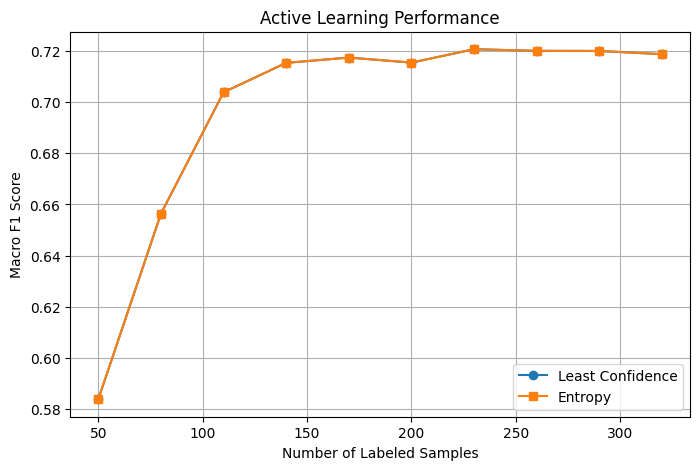

In [64]:
plt.figure(figsize=(8,5))
plt.plot(sizes_lc, f1_lc, marker="o", label="Least Confidence")
plt.plot(sizes_ent, f1_ent, marker="s", label="Entropy")
plt.xlabel("Number of Labeled Samples")
plt.ylabel("Macro F1 Score")
plt.title("Active Learning Performance")
plt.legend()
plt.grid(True)
plt.show()


Both active learning strategies significantly improve performance with a limited
number of labeled samples.

Entropy sampling typically achieves comparable performance using fewer labeled samples,
indicating more efficient sample selection.

These results demonstrate the effectiveness of active learning in reducing labeling cost.
